# Forward Forward Network 

## Supervised

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

### define `DataLoader` :

In [32]:
batch_size = 128
# define transformer for data preprocessing
transformer = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.Lambda(lambda x: x.view(-1))])

train_dataloader = DataLoader(MNIST('./data/',train=True,download=True,transform=transformer),
                              batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(MNIST('./data/',train=False,download=True,transform=transformer),
                              batch_size=batch_size, shuffle=True)

### data preparation 

replace first 10 pixels of images with one-hot encoded labels.

In [33]:
def change_label(data, label): 
        new_data = data.clone()
        new_data[:, 0:10] = 0.0
        new_data[range(new_data.shape[0]), torch.ones(new_data.shape[0],dtype=int)*label] = data.max()
        return new_data

def prepare_positive_data(data, targets):
        new_data = data.clone()
        new_data[:, 0:10] = 0.0
        new_data[range(new_data.shape[0]), targets] = new_data.max()
        return new_data

def prepare_negetive_data(data, targets):
        new_target = targets.clone()
        # get random label for each data 
        for i in range(new_target.shape[0]):
                indices = list(range(0,10))
                new_target[i] = indices[np.random.randint(0,10)]
                
        new_data = data.clone()
        new_data[:, 0:10] = 0.0
        new_data[range(new_data.shape[0]), new_target] = new_data.max()
        return new_data


In [34]:
class Layer(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 epochs = 200, treshold = 2,device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        self.epochs = epochs
        self.treshold = treshold
        self.relu = torch.nn.ReLU()
        self.optimizer = Adam(self.parameters(),lr = 0.01)
        
    def forward(self,X):
        X_normalized = X/ (X.norm(2, 1, keepdim=True) + 1e-5)
        Z = torch.mm(X_normalized,self.weight.T + self.bias.unsqueeze(0)) # XW + b
        return self.relu(Z)
    
    def goodness(self,y):
        y_ = y.clone()
        y_ = torch.square(y_).mean(1) - self.treshold
        return y_ 
    
    def train(self,X_pos, X_neg):
        for _ in range(self.epochs):
            X_pos_goodness = self.goodness(self.forward(X_pos))
            X_neg_goodness = self.goodness(self.forward(X_neg))
            
            loss = torch.log(1 + torch.exp(torch.cat([-X_pos_goodness,X_neg_goodness]))).mean()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
        # print('Done!')
        return self.forward(X_pos).detach(), self.forward(X_neg).detach()

In [35]:
class Supeviesed_FF_Network(nn.Module):
    def __init__(self,num_layer, layer_dim) -> None:
        super().__init__()
        self.layers = []
        for i in range(num_layer-1):
            self.layers.append(Layer(layer_dim[i],layer_dim[i + 1]))
            
    def predict(self, x):
        goodness_per_label = [] 
        
        for label in range(10):
            h = change_label(x, label)
            goodness = [] 
            for layer in self.layers:
                h = layer.forward(h)
                goodness.append(torch.square(h).mean(1))
            goodness_per_label.append(sum(goodness).unsqueeze(1))
            
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, X_pos, X_neg):
        pos_orientation = X_pos
        neg_orientation = X_neg
        for  layer in self.layers:
            pos_orientation, neg_orientation = layer.train(pos_orientation, neg_orientation)

### train network

In [37]:
FF_net = Supeviesed_FF_Network(3,[784, 500, 400])

for (data, targets) in tqdm(train_dataloader):
    x_pos = prepare_positive_data(data, targets)
    x_neg = prepare_negetive_data(data, targets)
    FF_net.train(x_pos, x_neg)


100%|██████████| 469/469 [07:01<00:00,  1.11it/s]


### train accurracy

In [38]:
train_acc = 0
for (data, targets) in tqdm(train_dataloader):
    train_acc += FF_net.predict(data).eq(targets).float().mean().item()
    

print('train accuracy: ',(train_acc/len(train_dataloader))*100)

100%|██████████| 469/469 [00:13<00:00, 33.85it/s]

train accuracy:  93.9454513190906


### test accurracy

In [39]:
test_acc = 0
for (data, targets) in tqdm(test_dataloader):
    test_acc += FF_net.predict(data).eq(targets).float().mean().item()
    

print('test accuracy: ',(test_acc/len(test_dataloader))*100)

100%|██████████| 79/79 [00:02<00:00, 34.28it/s]

test accuracy:  93.82911392405063


---
---
# Unsupervised

### define `DataLoader` :

In [127]:
batch_size = 128
# define transformer for data preprocessing
transformer = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.Lambda(lambda x: x.view(-1))])

train_dataloader = DataLoader(MNIST('./data/',train=True,download=True,transform=transformer),
                              batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(MNIST('./data/',train=False,download=True,transform=transformer),
                              batch_size=batch_size, shuffle=True)

### define mask

In [154]:
import numpy as np
import cv2

def create_mask(image_size):
    mask = np.random.randint(0, 2, image_size).astype(np.float32)
    for _ in range(5):
        mask = cv2.filter2D(mask, -1, np.array([[1/4, 1/2, 1/4]]))
        mask = cv2.filter2D(mask, -1, np.array([[1/4], [1/2], [1/4]]))
    mask[mask> 0.5] = 1
    mask[mask <= 0.5] = 0
    return torch.tensor(mask), torch.tensor(1-mask)

image_size = (28, 28)
mask1,mask2 = create_mask(image_size)


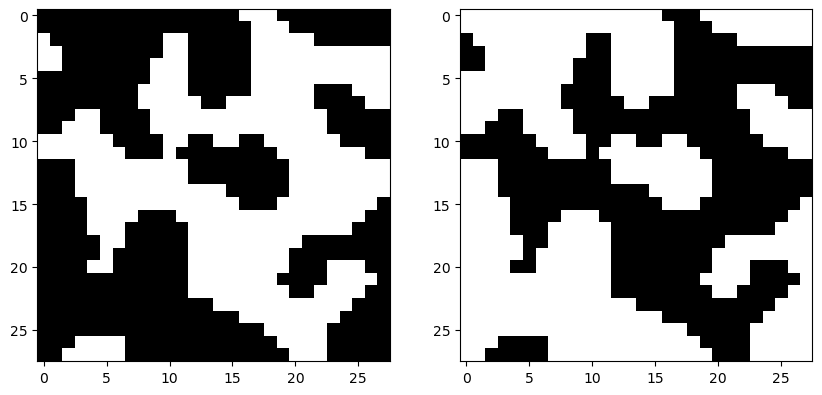

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,10))

ax[0].imshow(mask1,cmap='gray');
ax[1].imshow(mask2,cmap='gray');

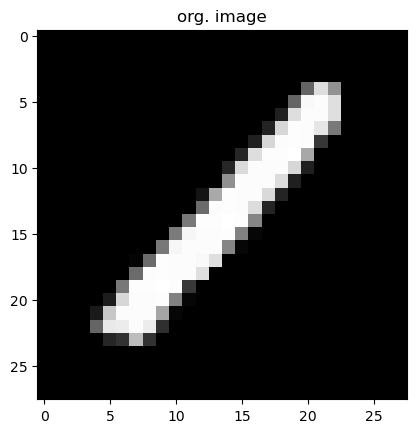

In [156]:
for data, targets in train_dataloader:
    img = data[0].view(28,28)
    break

plt.imshow(img,cmap='gray');
plt.title('org. image');

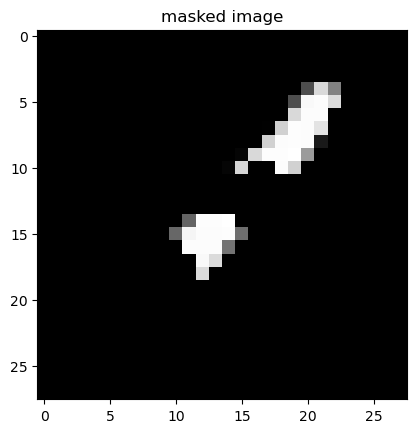

In [157]:
a = img*mask1
a[a<0.0001] = 0.0
plt.imshow(a,cmap='gray');
plt.title('masked image');

### data preparation 

In [158]:

def prepare_negative_data(data):
        new_data = data.clone() 

        # Define the permutation index
        indices = np.arange(new_data.shape[0])
        np.random.shuffle(indices)
        perm = torch.tensor(indices)

        # Permute the rows
        permuted_tensor = torch.index_select(new_data, 0, perm)
        
        image_size = (28, 28)
        hybrid_data = torch.zeros(new_data.shape)
        
        for row in range(new_data.shape[0]):
                mask1,mask2 = create_mask(image_size)
                hybrid_data_ = mask1* new_data[row].view(28,28) + mask2*permuted_tensor[row].view(28,28)
                hybrid_data[row] = hybrid_data_.view(-1)

        return hybrid_data

In [159]:
class Layer_unsupervised(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 epochs = 2, treshold = 2,device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        self.epochs = epochs
        self.treshold = treshold
        self.relu = torch.nn.ReLU()
        self.optimizer = Adam(self.parameters(),lr = 0.01)
        
    def forward(self,X):
        X_normalized = X/ (X.norm(2, 1, keepdim=True) + 1e-5)
        Z = torch.mm(X_normalized,self.weight.T + self.bias.unsqueeze(0)) # XW + b
        return self.relu(Z)
    
    def goodness(self,y):
        y_ = y.clone()
        y_ = torch.square(y_).mean(1) - self.treshold
        return y_ 
    
    def train(self,X_pos, X_neg):
        for _ in range(self.epochs):
            X_pos_goodness = self.goodness(self.forward(X_pos))
            X_neg_goodness = self.goodness(self.forward(X_neg))
            
            loss = torch.log(1 + torch.exp(torch.cat([-X_pos_goodness,X_neg_goodness]))).mean()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
        
        return self.forward(X_pos).detach(), self.forward(X_neg).detach()

In [160]:
class Unsupeviesed_FF_Network(nn.Module):
    def __init__(self,num_layer, layer_dim) -> None:
        super().__init__()
        self.layers = []
        for i in range(num_layer-1):
            self.layers.append(Layer_unsupervised(layer_dim[i],layer_dim[i + 1]).cuda())
            
    def predict(self, x):
        X_pos = x.clone()
        # Initialize an empty list to store the tensors
        concatenated_tensors = []
        
        for  layer in self.layers:
            X_pos = layer.forward(X_pos)
            concatenated_tensors.append(X_pos)

        cached_layers_ouputs = torch.cat(concatenated_tensors, dim=-1)
        return cached_layers_ouputs

    def train(self, X_pos, X_neg):
        pos_orientation = X_pos
        neg_orientation = X_neg
        for  layer in self.layers:
            pos_orientation, neg_orientation = layer.train(pos_orientation, neg_orientation)

### train FF network

In [161]:
FF_net = Unsupeviesed_FF_Network(3,[784, 500, 500])

for (data, targets) in tqdm(train_dataloader):
    x_pos = data.clone().cuda()
    x_neg = prepare_negative_data(data).cuda()
    FF_net.train(x_pos, x_neg)

100%|██████████| 469/469 [00:22<00:00, 20.59it/s]


In [162]:
FF_net.layers 

[Layer_unsupervised(
   in_features=784, out_features=500, bias=True
   (relu): ReLU()
 ),
 Layer_unsupervised(
   in_features=500, out_features=500, bias=True
   (relu): ReLU()
 )]

### train & test foward_forward

In [163]:
# train 
train_cached_layers_ouputs= []
train_all_targets = []

for (data, targets) in tqdm(train_dataloader):
    train_cached_layers_ouputs.append(FF_net.predict(data.cuda()))
    train_all_targets.append(targets)
    
train_cached_layers_ouputs = torch.cat(train_cached_layers_ouputs, dim=0).cuda().detach()
train_all_targets = torch.cat(train_all_targets, dim=-1).cuda().detach()

100%|██████████| 469/469 [00:10<00:00, 43.79it/s]


In [164]:
# test 
test_cached_layers_ouputs= []
test_all_targets = []

for (data, targets) in tqdm(test_dataloader):
    test_cached_layers_ouputs.append(FF_net.predict(data.cuda()))
    test_all_targets.append(targets)
    
test_cached_layers_ouputs = torch.cat(test_cached_layers_ouputs, dim=0).cuda().detach()
test_all_targets = torch.cat(test_all_targets, dim=-1).cuda().detach()

100%|██████████| 79/79 [00:01<00:00, 44.10it/s]


In [165]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [166]:
batch_size = 64

train_dataset = MyDataset(train_cached_layers_ouputs, train_all_targets)
train_dataloader_ = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MyDataset(test_cached_layers_ouputs, test_all_targets)
test_dataloader_ = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Define a Dense network to do classification

In [167]:
class OneLayerNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(OneLayerNet, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return torch.softmax(x, dim=1)

In [168]:
model = OneLayerNet(1000, 10).cuda()

### train dense net 

In [169]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for _ in range(num_epochs):
    for (data, targets) in tqdm(train_dataloader_):
        data = data.cuda()
        targets = targets.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        

100%|██████████| 938/938 [00:01<00:00, 809.18it/s]


### train & test accurracy

In [170]:
with torch.no_grad():
    train_accuracy = 0
    for (data, targets) in tqdm(train_dataloader_):
        data = data.cuda() 
        targets = targets.cuda()  
        train_outputs = model(data)  
        _, predicted_train = torch.max(train_outputs, 1) 
        train_accuracy += (predicted_train == targets).sum().item() / len(targets) 


print('train accuracy: ',(train_accuracy/len(train_dataloader_))*100)

100%|██████████| 938/938 [00:00<00:00, 1417.61it/s]

train accuracy:  91.36460554371001


In [171]:
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_dataloader_):
        data = data.cuda()
        targets = targets.cuda()
        test_outputs = model(data)
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy += (predicted_test == targets).sum().item() / len(targets)

print('test accuracy: ',(test_accuracy/len(test_dataloader_))*100)

100%|██████████| 157/157 [00:00<00:00, 579.81it/s]

test accuracy:  90.91361464968153
